In [1]:
import torch 
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
# from traffic_dataset_v4 import LoadData  # pems 04 07 08
from traffic_dataset_v5 import LoadData # pems 03
import matplotlib.pyplot as plt
import os

In [2]:
'''
get ground truth
'''
batch_size = 32
ID_of_dataset = 3
num_of_node = 358 #PEMS03 358 PEMS04 307 PEMS07 883 PEMS08 170
data_csv_file = "/data/PEMS0{}/PEMS0{}.csv".format(ID_of_dataset, ID_of_dataset) # path of csv file
data_npz_file = "/data/PEMS0{}/PEMS0{}.npz".format(ID_of_dataset, ID_of_dataset) # path of npz file 

test_data = LoadData(data_path=[data_csv_file, data_npz_file],
                        num_nodes=num_of_node,
                        divide_rate=[0.8, 0.2],
                        history_length=12,
                        pre_length = 12,
                        train_mode="test"
                        )

test_loader = DataLoader(test_data, batch_size=batch_size)
device = torch.device("cpu")
graph_data = test_data[0]["graph"].to(device)

num = 0
all_y_true = 0
for data in test_loader:
    if num == 0:
        all_y_true = data["flow_y"]
    else:
        all_y_true = torch.cat([all_y_true, data["flow_y"]], dim=0) 
    num += 1

In [30]:
'''
get predicted value
'''
def process_graph(graph_data):
    N = graph_data.size(0)
    matrix_i = torch.eye(N, dtype=graph_data.dtype, device=graph_data.device) 
    graph_data += matrix_i # A~  [N,N]
    degree_matrix = torch.sum(graph_data, dim=-1, keepdim=False) 
    degree_matrix = degree_matrix.pow(-1) 
    degree_matrix[degree_matrix == float("inf")] = 0.
    degree_matrix = torch.diag(degree_matrix) 
    return torch.mm(degree_matrix, graph_data) 


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
batch_size_ = 32
data_id = 3
num_nodes = 358 # pems03 358 pems04 307 pems07 883 pems08 170
data_csv_file = "/data/PEMS0{}/PEMS0{}.csv".format(data_id, data_id) # path of csv file
data_npz_file = "/data/PEMS0{}/PEMS0{}.npz".format(data_id, data_id) # path of npz file 

test_data = LoadData(data_path=[data_csv_file, data_npz_file],
                        num_nodes=num_nodes,
                        divide_rate=[0.8, 0.2],
                        history_length=12,
                        pre_length = 12,
                        train_mode="test"
                        )

test_loader = DataLoader(test_data, batch_size=batch_size_)
device = torch.device("cuda:0")
graph_data = test_data[0]["graph"].to(device)
graph_data = process_graph(graph_data)

for i in range(5):
    my_net = torch.load("/StarG2N/pems03/PEMS03_{}.pt".format(i)) # loading model

    my_net.eval() 
    with torch.no_grad(): 
        num = 0
        all_predict_value = 0
        for data in test_loader:
            flow_x = data["flow_x"].to(device)    # [B, N, H, D]
            B, N= flow_x.size(0), flow_x.size(1)
            flow_x = flow_x.view(B, N, -1) # [B, N, H * D] H = 6 D = 1
            predict_value = my_net(flow_x, graph_data, B, N).to(torch.device("cpu"))
            if num == 0:
                all_predict_value = predict_value
            else:
                all_predict_value = torch.cat([all_predict_value, predict_value], dim=0)
            num += 1  
    if i == 0:
        predict_value_temp = all_predict_value
    else:
        predict_value_temp = torch.add(predict_value_temp, all_predict_value)
predict_value_temp = predict_value_temp / 5


In [13]:
from traffice_dataset_normal import LoadData as LoadData01

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
batch_size_ = 32
data_id = 3
num_nodes = 358 # pems03 358 pems04 307 pems07 883 pems08 170
data_csv_file = "/data/PEMS0{}/PEMS0{}.csv".format(data_id, data_id) # path of csv file
data_npz_file = "/data/PEMS0{}/PEMS0{}.npz".format(data_id, data_id) # path of npz file

test_data = LoadData01(data_path=[data_csv_file, data_npz_file],
                        num_nodes=num_nodes,
                        divide_rate=[0.8, 0.2],
                        history_length=12,
                        pre_length = 12,
                        train_mode="test"
                        )

test_loader = DataLoader(test_data, batch_size=batch_size_)
device = torch.device("cuda:0")
graph_data = test_data[0]["graph"].to(device)
graph_data = process_graph(graph_data)

# attention
for i in range(5):
    my_net = torch.load("/Baseline/Attention/pems03/PEMS03_test_400epoch_{}.pt".format(i))
    my_net.eval() 
    with torch.no_grad(): 
        num = 0
        all_predict_value = 0
        for data in test_loader:
            flow_x = data["flow_x"].to(device)    # [B, N, H, D]
            B, N= flow_x.size(0), flow_x.size(1)
            flow_x = flow_x.view(B, N, -1) # [B, N, H * D] H = 6 D = 1
            predict_value = my_net(flow_x, N).to(torch.device("cpu"))
            if num == 0:
                all_predict_value = predict_value
            else:
                all_predict_value = torch.cat([all_predict_value, predict_value], dim=0)
            num += 1  
    if i == 0:
        predict_value_temp = all_predict_value
    else:
        predict_value_temp = torch.add(predict_value_temp, all_predict_value)
Attention_value_temp = predict_value_temp / 5
print("attention done")

# ChebNet
for i in range(5):
    my_net = torch.load("/Baseline/ChebNet/pems03/PEMS03_test_400epoch_{}.pt".format(i))
    my_net.eval() 
    with torch.no_grad(): 
        num = 0
        all_predict_value = 0
        for data in test_loader:
            flow_x = data["flow_x"].to(device)    # [B, N, H, D]
            B, N= flow_x.size(0), flow_x.size(1)
            flow_x = flow_x.view(B, N, -1) # [B, N, H * D] H = 6 D = 1
            predict_value = my_net(flow_x, graph_data).to(torch.device("cpu"))
            if num == 0:
                all_predict_value = predict_value
            else:
                all_predict_value = torch.cat([all_predict_value, predict_value], dim=0)
            num += 1  
    if i == 0:
        predict_value_temp = all_predict_value
    else:
        predict_value_temp = torch.add(predict_value_temp, all_predict_value)
Chebnet_value_temp = predict_value_temp / 5
print("chebnet done")

# GRU 
for i in range(5):
    my_net = torch.load("/Baseline/GRU/pems03/PEMS03_test_400epoch_{}.pt".format(i))
    my_net.eval()
    with torch.no_grad():
        num = 0
        all_predict_value = 0
        for data in test_loader:
            flow_x = data["flow_x"].to(device)    # [B, N, H, D]
            B, N= flow_x.size(0), flow_x.size(1)
            flow_x = flow_x.view(B, N, -1) # [B, N, H * D] H = 6 D = 1
            predict_value = my_net(flow_x, graph_data).to(torch.device("cpu"))
            if num == 0:
                all_predict_value = predict_value
            else:
                all_predict_value = torch.cat([all_predict_value, predict_value], dim=0)
            num += 1  
    if i == 0:
        predict_value_temp = all_predict_value
    else:
        predict_value_temp = torch.add(predict_value_temp, all_predict_value)
GRU_value_temp = predict_value_temp / 5
print("GRU done")

# T-GCN
for i in range(5):
    my_net = torch.load("/Baseline/T-GCN/pems03/PEMS03_test_400epoch_{}.pt".format(i))
    my_net.eval()
    with torch.no_grad():
        num = 0
        all_predict_value = 0
        for data in test_loader:
            flow_x = data["flow_x"].to(device)    # [B, N, H, D]
            B, N= flow_x.size(0), flow_x.size(1)
            flow_x = flow_x.view(B, N, -1) # [B, N, H * D] H = 6 D = 1
            predict_value = my_net(flow_x, graph_data).to(torch.device("cpu"))
            if num == 0:
                all_predict_value = predict_value
            else:
                all_predict_value = torch.cat([all_predict_value, predict_value], dim=0)
            num += 1  
    if i == 0:
        predict_value_temp = all_predict_value
    else:
        predict_value_temp = torch.add(predict_value_temp, all_predict_value)
TGCN_value_temp = predict_value_temp / 5
print("TGCN done")

attention done
chebnet done
GRU done
TGCN done


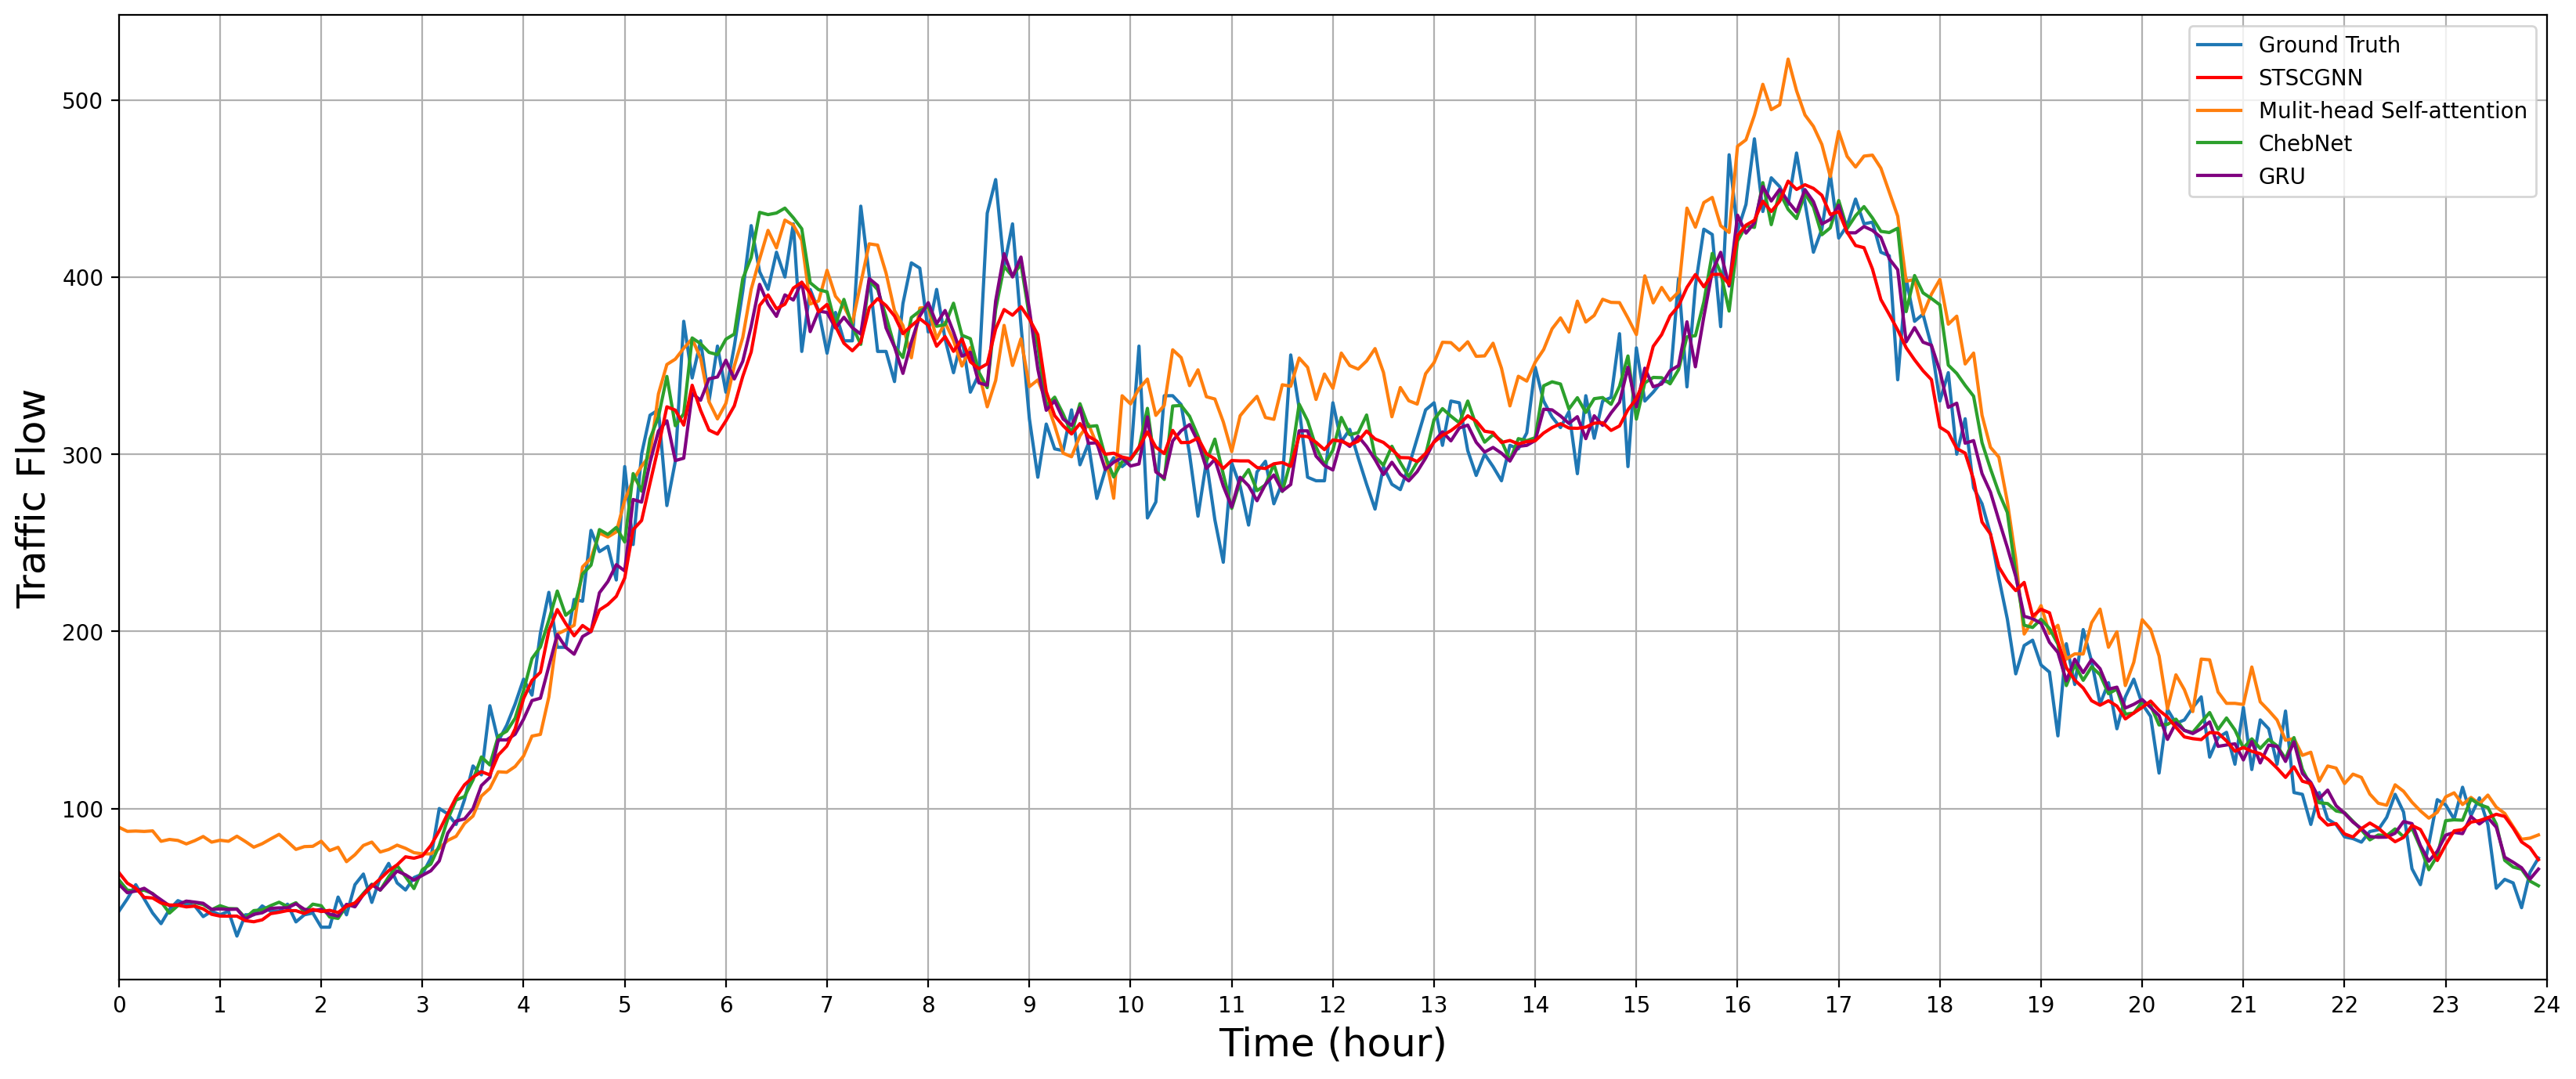

In [45]:
# plot
node_id = 20
ground_truth = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],all_y_true)[12*6:24*12+12*6, node_id,0,0]
predict_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],predict_value_temp)[12*6:24*12+12*6, node_id,0,0]
Attention_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],Attention_value_temp)[12*6:24*12+12*6, node_id,0,0]
Chebnet_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],Chebnet_value_temp)[12*6:24*12+12*6, node_id,0,0]
GRU_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],GRU_value_temp)[12*6:24*12+12*6, node_id,0,0]
# TGCN_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],TGCN_value_temp)[12*6:24*12+12*6, node_id,0,0]

ground_truth_label = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24"]
x_values = range(0, 300)
plt.figure(dpi=200, figsize=(20,8))
lin1, = plt.plot(ground_truth)

lin3, = plt.plot(Attention_value)
lin4, = plt.plot(Chebnet_value)
lin5, = plt.plot(GRU_value, color='purple')

lin2, = plt.plot(predict_value, color='red')

plt.xlim(0, 300 - 12)
plt.xlabel('Time (hour)',fontsize=18)
plt.ylabel('Traffic Flow',fontsize=18)
plt.grid(True)
plt.xticks(ticks=list(x_values[::12]), labels=ground_truth_label)
plt.legend(handles=[lin1,lin2,lin3,lin4,lin5], labels=["Ground Truth", "STSCGNN", "Mulit-head Self-attention", "ChebNet", "GRU"])
plt.show()

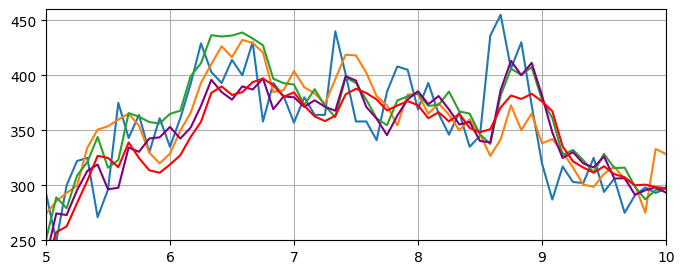

In [57]:
'''
绘制真实交通数据
'''
node_id = 20
ground_truth = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],all_y_true)[12*6:24*12+12*6, node_id,0,0]

predict_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],predict_value_temp)[12*6:24*12+12*6, node_id,0,0]

Attention_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],Attention_value_temp)[12*6:24*12+12*6, node_id,0,0]
Chebnet_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],Chebnet_value_temp)[12*6:24*12+12*6, node_id,0,0]
GRU_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],GRU_value_temp)[12*6:24*12+12*6, node_id,0,0]
# TGCN_value = test_data.recover_data(test_data.flow_norm[0],test_data.flow_norm[1],TGCN_value_temp)[12*6:24*12+12*6, node_id,0,0]

ground_truth_label = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24"]
x_values = range(0, 300)
plt.figure(dpi=100, figsize=(8,3))

lin1, = plt.plot(ground_truth)

lin3, = plt.plot(Attention_value)
lin4, = plt.plot(Chebnet_value)
lin5, = plt.plot(GRU_value, color='purple')

lin2, = plt.plot(predict_value, color='red')


# plt.xlabel('Time (hour)',fontsize=18)
# plt.ylabel('Traffic Flow',fontsize=18)
plt.grid(True)
plt.xticks(ticks=list(x_values[::12]), labels=ground_truth_label)
# plt.legend(handles=[lin1,lin2,lin3,lin4,lin5], labels=["Ground Truth", "STSCGNN", "Mulit-head Self-attention", "ChebNet", "GRU"])
# plt.legend(handles=[lin1,lin2], labels=["Ground Truth", "STSCGNN"])
plt.ylim(250, 460)
plt.xlim(60, 120)
plt.show()